## 对流方程
不含源项的对流方程如下

$$
\partial_t u(x, t) + v \partial_x u(x, t) = 0
$$

其中 $u(x,t = 0)$ 是$t = 0$时刻的位移波形（初始条件），它以速度 $v$ 进行对流。

## 有限差分方法求解数值解

有限差分方法允许我们对该方程进行数值求解。本笔记本使用了四种方案，首先是高度耗散的Euler方法，其次是预测-校正方法或Heun方法，最后是McCormak方案和Lax Wendroff方案。


#### 欧拉方法
欧拉方法是用于求解带有初始条件的一阶微分方程的数值积分中最基本的方法。其一般公式如下，
$$
u_{n+1} = u_n + \Delta t f(u_n, t_n)
$$
其中 $u$ 是速度场，$t$ 是时间，$\Delta t$ 是步长，$f$ 是对流方程右侧的线性算子，在这种情况下为 $f(u_n, t_n) =  - v \partial_x u(x, t)$。 
这个线性算子是空间域 $x$ 的偏导数，可使用中心或向后有限差分方案计算。

#### 中心有限差分方案
该方案用于求解抛物型偏微分方程，尽管对流方程是双曲型方程，但本笔记本中采用该方法以查看输出行为。它产生不稳定解，可以通过添加额外的粘度项进行修正（参见下面的Lax Wendroff近似）。 使用中心方案对对流方程进行离散化，我们得到

$$
\frac{u_i^{n+1}- u_i^n}{\Delta t} + v \frac{u_{i+1}^n - u_{i-1}^n}{2 \Delta x} = 0
$$

导出方程

$$
u_i^{n+1} = u_i^n - v \frac{\Delta t}{2 \Delta x} (u_{i+1}^n + u_{i-1}^n)
$$。

#### 上风有限差分方案
上风有限差分方案是用于求解双曲型偏微分方程（如对流方程）的数值方法。它使用前一步的差分，传播方向由速度的符号确定。在这种情况下，对流方程如下

$$
\frac{u_i^{n+1}- u_i^n}{\Delta t} + v \frac{u_{i}^n - u_{i-1}^n}{\Delta x} = 0
$$

导出方程

$$
u_i^{n+1} = u_i^n - v \frac{\Delta t}{\Delta x} (u_{i}^n + u_{i-1}^n)
$$。


In [6]:
# Import Libraries (PLEASE RUN THIS CODE FIRST!) 
# ----------------------------------------------
%matplotlib nbagg
%matplotlib inline
import math
import numpy as np
import matplotlib.pylab as plt

# Show Plot in The Notebook
#plt.switch_backend("nbagg")

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [7]:
# PARAMATER CONFIGURATION
# ---------------------------------------------------------------------------
nx = 1250          # Number of grid points.
v = 5500.          # Acoustic velocity in m/s.
x_max = 10000      # Length of the domain in m.
eps = 0.9          # CFL
tmax = 1.0         # Simulation time in s
isnap = 2          # Plot the solution each `isnap` timesteps.
sig = 100          # Sigma for the gaussian source time function
x0 = 1000          # Center point of the source time function

In [8]:
# INITIALIZE COORDINATES AND SET UP THE MODEL

# Choose between the finite difference scheme: "upwind" or a "centered"
# -------------------------
fd_type = "upwind"
#fd_type = "centered"


# Spatial setup
# -------------------------
x = np.linspace(0, x_max, nx)
dx = x[1] - x[0]

# Use wave based CFL criterion, time step will be calculated from stability criterion
dt = eps * dx / v

# Simulation time
# -------------------------
nt = int(tmax / dt)

# Initial condition in space
# -------------------------
sx = np.exp(-1.0 / sig ** 2.0 * (x - x0) ** 2.0);

# Initialize fields
# -------------------------
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)


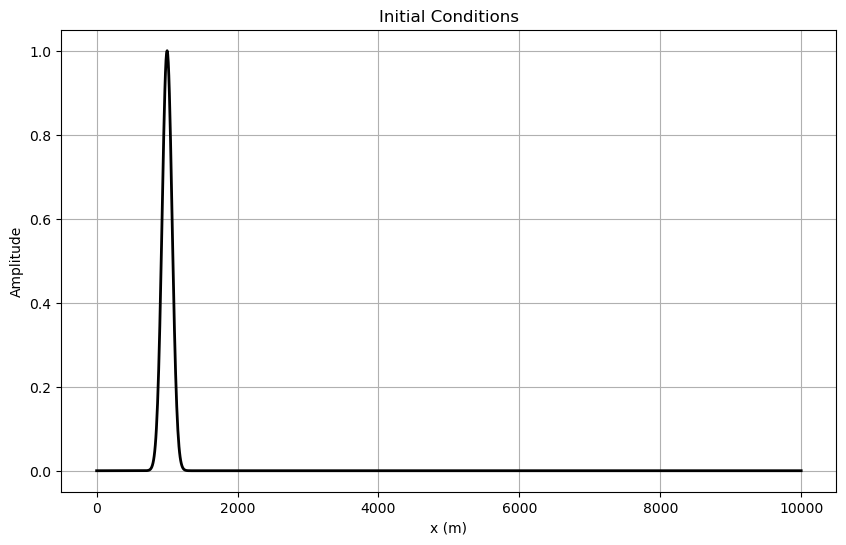

In [9]:
# Plot the initial conditions
plt.close()
plt.figure(figsize=(10,6))
plt.title("Initial Conditions")
plt.grid()
plt.plot(x, u, color="black", lw=2)
plt.xlabel("x (m)")
plt.ylabel("Amplitude")
plt.show()

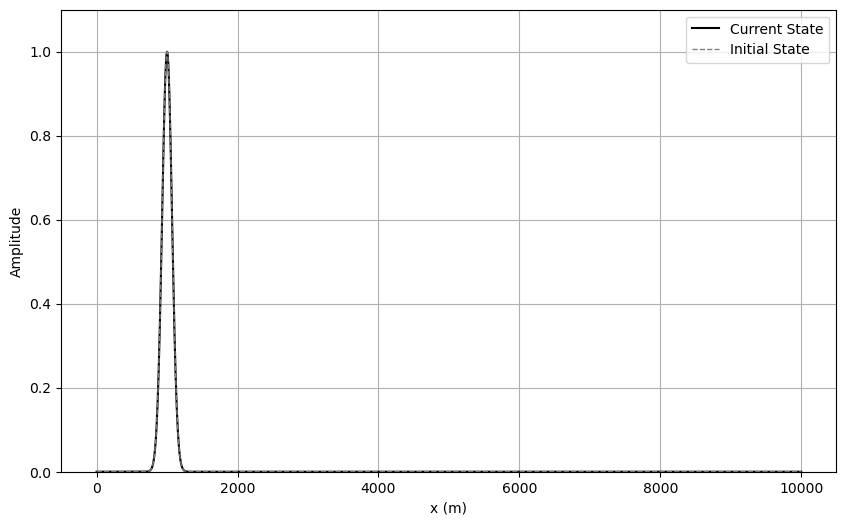

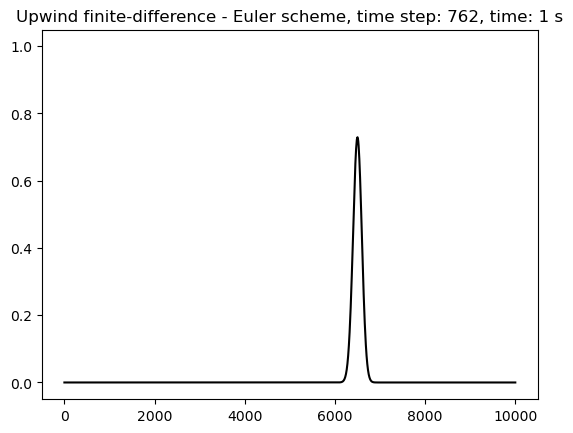

In [10]:
# Advection Equation - Euler Scheme

# Plot the initial condition for comparison 
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")
plt.xlabel("x (m)")
plt.ylabel("Amplitude")
if fd_type == "upwind":
    title = "Upwind finite-difference - Euler scheme"
elif fd_type == "centered":
    title = "Centered finite-difference- Euler scheme"
else:
    raise ValueError("fd_type must be 'forward' or 'centered'")

plt.grid() 
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()

# Here we start the actual time extrapolation 
# Calculate the space derivative of u(x) and write it into du(x) 
for i in range(nt):
    du[:] = 0.0
    for j in range(1, nx - 1):
        if fd_type == "upwind":
            du[j] = (u[j] - u[j - 1]) / dx
        elif fd_type == "centered":
            du[j] = (u[j + 1] - u[j - 1]) / (2.0 * dx)

    # time extrapolation scheme (Euler)
    unew = u - dt * v * du

    # The new presence is the current future!
    u = unew
    
    # Update plot.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)        
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()        
plt.ioff()

#### 预测-校正方法
预测-校正方法或Heun方法源自欧拉方法和梯形规则。让我们将对流方程重新写为
$$
\partial_t u(x,t) = f(u,t) = - v\partial_x u(x,t) 
$$
其中 $u$ 是解速度场，$v$ 是速度，$f$ 是线性算子。 

一阶欧拉方案对应于 
$$
\tilde{u} = u(x, t+\Delta t) = u(x,t) + \Delta t f(u, t)
$$

一旦我们获得速度场 $\partial_x u(x,t)$ 的偏导数，该偏导数来自算子 $f$，使用上风有限差分方案计算，就可以应用Heun方法，步骤如下：

* 第一步是预测步：计算上一时间步的线性算子 $f$。
$$
  k1 = f(u,t) = f(u^n, t^n) 
$$
* 第二步是校正步：计算当前时间步的线性算子，该线性算子是未知的，因此使用从一阶欧拉方案得到的表达式计算。
$$
 k2 = f(\tilde{u}, t+ \Delta t) = f(\tilde{u}^{n+1}, t^{n+1})  
$$
* 最后：利用梯形规则改进初始猜测，并获得速度场的解
$$
u^{n+1} = u^n + \frac{\Delta t}{2}(k1 + k2)
$$


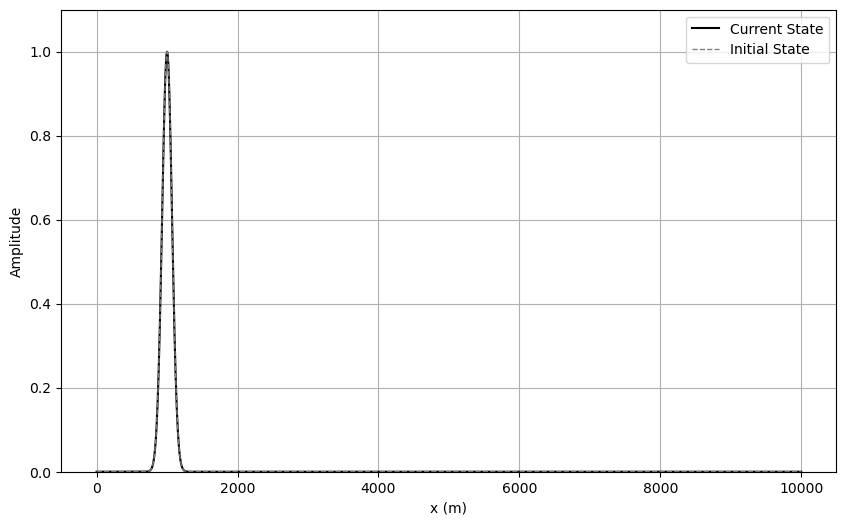

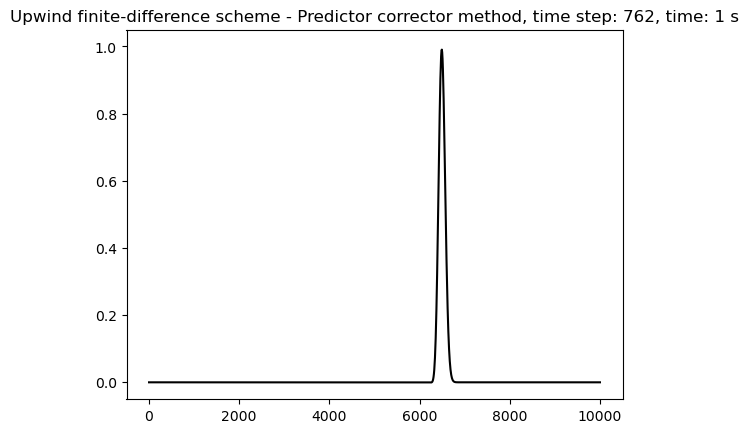

In [11]:
# Advection Equation - Predictor Corrector Scheme

# Initial conditions
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)


# Plot the initial condition for comparison 
# Initialize figures
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")

plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "Upwind finite-difference scheme - Predictor corrector method"

plt.grid() 
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# # Here we start the actual time extrapolation, the task for you is to calculate 
# the space derivative of u(x) and write it into du(x) 

for i in range(nt):
    du[:] = 0.0
    # Calculate the spatial derivative using the upwind approach
    for j in range(1, nx - 1):
            du[j] = (u[j] - u[j - 1]) / dx

    # time extrapolation
    # predictor
    k1 = v * du
    q = u - dt*v*du
    
    unew = q

    # corrector 
    for j in range(1, nx - 1):
        du[j]=(q[j+1]-q[j])/dx
    k2 = v*du
    
    # predictor corrector extrapolation
    unew = u - 0.5*dt*(k1+k2)

# The new presence is the current future!
    u = unew
    
    # Update plot if desired.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)
        
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()    

    
plt.ioff()

#### McCormack方案
McCormack方案也用于求解一阶双曲型偏微分方程，被认为是二阶有限差分方法。其算法如下：
* 首先使用带有上风近似的欧拉方法来计算解 $u_i^{\overline{n+1}}$
$$
u_i^{\overline{n+1}} = u_i^n - v \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n)
$$

* 然后计算校正项并更新解
$$
u_i^{n+1}=\frac{u_i^n+u_i^{\overline{n+1}}}{2}-v\frac{\Delta t}{2\Delta x}(u_{i+1}^{\overline{n+1}}-u_i^{\overline{n+1}})
$$
上述方程中的第一项是通过欧拉方法计算得到的解 $u_i^{\overline{n+1}}$ 与当前解 $u_i^n$ 的平均值。第二项是使用欧拉近似中的解 $u_i^{\overline{n+1}}$ 进行前向差分逼近。


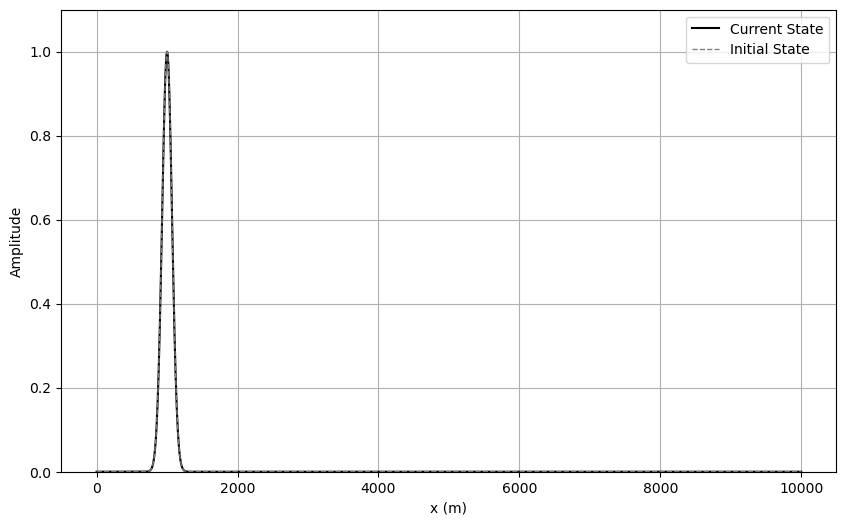

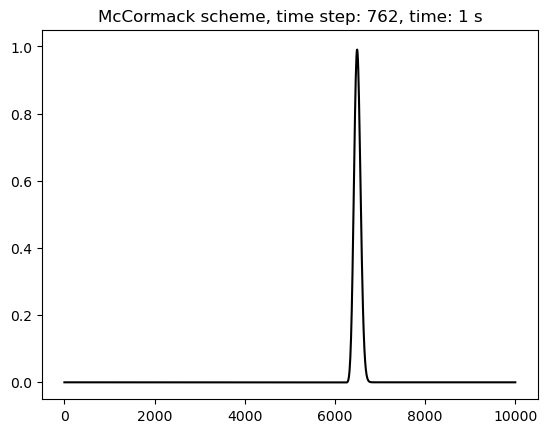

In [12]:
# Advection Equation - McCormack Scheme

# Initial conditions
u = sx
unew = np.zeros(nx)
du = np.zeros(nx)
k1 = np.zeros(nx)
k2 = np.zeros(nx)
q = np.zeros(nx)


# Plot the initial condition for comparison 
# Initialize figures
plt.figure(figsize=(10, 6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")

plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "McCormack scheme"

plt.grid() 
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# # Here we start the actual time extrapolation, the task for you is to calculate 
# the space derivative of u(x) and write it into du(x) 

for i in range(nt):
    du[:] = 0.0
    # Calculate the spatial derivative using the upwind approach
    for j in range(1, nx - 1):
            du[j] = (u[j] - u[j - 1]) / dx

    # time extrapolation
    # 1st step
    q = u - dt*v*du
    
    # 2nd step 
    for j in range(1, nx - 1):
        du[j]=(q[j+1]-q[j])/dx
    
    # update
    unew = 0.5*(u + q) - v*dt*0.5*du
    # The new presence is the current future!
    u = unew
    
    # Update plot if desired.
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)
        
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()    

    
plt.ioff()

#### Lax Wendroff方案
最后，Lax Wendroff方案也用于求解双曲型偏微分方程，被认为是时空域的二阶方法。它使用对 $u_i^{n+1}$ 的Taylor展开来得到，近似表示为
$$
u_i^{n+1} \approx u_i^{n} - \Delta t v \frac{\partial u}{\partial x}\Biggr\vert_i^n + \Delta t^2 v^2 \frac{\partial^2 u}{\partial^2 x} \Biggr\vert_i^n + ... 
$$

然后，速度场每个时间步的解为
$$
u_i^{n+1} = u_i^n - \frac{\Delta t}{2 \Delta x} v (u^n_{i+1}- u^n_{i-1}) + \frac{\Delta t^2}{2 \Delta x^2} v^2 (u_{i+1}^n - 2 u_i^n + u_{i-1}^n)
$$

这里使用了一个中心有限差分方案。


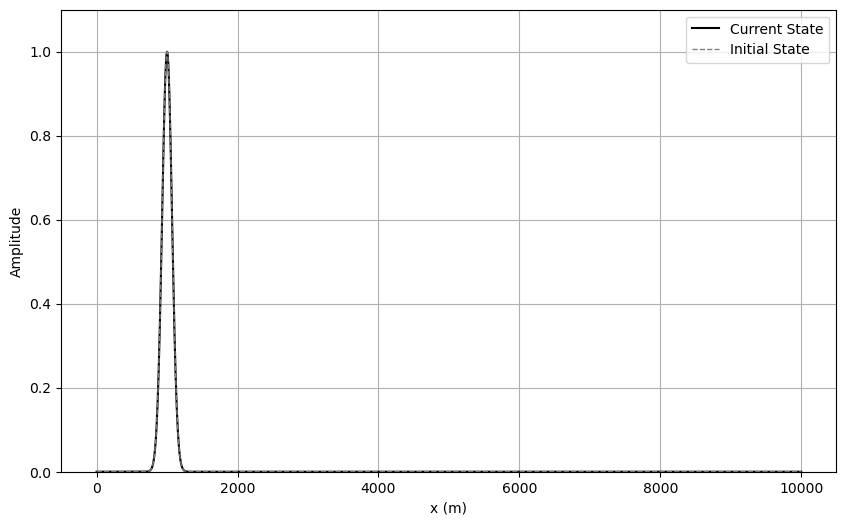

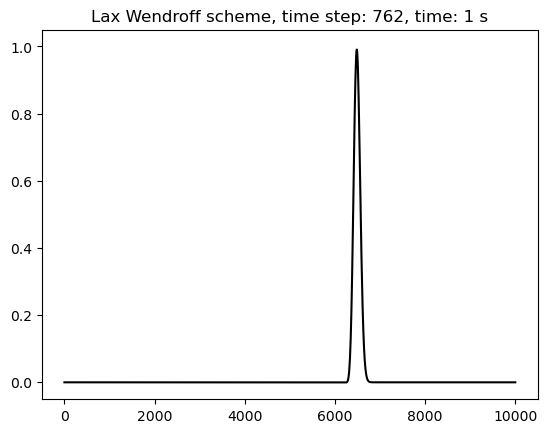

In [13]:
# Advection Equation - Lax Wendroff Scheme

# Initial conditions
u = sx
q = np.zeros(nx)
du = np.zeros(nx)

# plot the initial condition for comparison 
# Initialize figures
plt.figure(figsize=(10,6))
lines = plt.plot(x, u, color="black", lw=1.5, label="Current State")
plt.plot(x, u, color="0.5", ls="--", lw=1, label="Initial State")
plt.xlabel("x (m)")
plt.ylabel("Amplitude")
title = "Lax Wendroff scheme"
plt.grid() 
plt.ylim(u.min(), u.max() * 1.1)
plt.legend()
plt.ion()
plt.show()
# Lax Wendroff  scheme
for i in range(1,nt):
    # (central diff)
    for j in range(1,nx-1):
       # q =  a*(v[j+1]-2.*v[j]+v[j-1])
       # vnew[j]=v[j] + q
        du[j] = (u[j + 1] - u[j - 1]) / (2.0 * dx)
        q[j] = dt**2/(2.0*dx**2)*v**2*(u[j+1]-2.*u[j]+u[j-1])
    # time extrapolation scheme (Euler)
    unew = u - dt * v * du + q
    u = unew
    # time extrapolation
               
    # Plotting
 
    if not i % isnap:
        for l in lines:
            l.remove()
            del l
        lines = plt.plot(x, unew, color="black", lw=1.5)        
        plt.title(title + ", time step: %i, time: %.2g s" % (i, i * dt))
        plt.gcf().canvas.draw()        
plt.ioff()